# Milestone 2

**TODO:** General description of our project and what we seek to achieve

## Data Sanitizing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import gzip
%matplotlib inline

In [79]:
#AMAZON DATA
REVIEWS_PATH = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/reviews_Grocery_and_Gourmet_Food.json.gz"
META_PATH = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/meta_Grocery_and_Gourmet_Food.json.gz"
#FDA DATA
path_press_released = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_press_released_2011_2019.csv"
path_enforced = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_enforcements_2012-06_to_2019-10.csv"

Before starting our data import and exploration, we first need to convert the data to strict json. As explained in the site [from which the data comes from](http://jmcauley.ucsd.edu/data/amazon/links.html), the data is not in strict json, and thus we can not import as-is in a dataframe. To avoid us the hassle of reading the file in a dictionnary everytime we want to import it in a dataframe, we are going to create new files containing the reviews and metadata in appropriate format.

In [3]:
def sanitize(path, outpath):
    """Converts a given compressed json to strict json and writes it in a new file

    Parameters
    ----------
    path : str
    The file location of the gzip-compressed json file
    outpath : str
    The path to the desired output file location 

    """
    g = gzip.open(path, 'r')

    out = open(outpath, 'w')

    for l in g:
        out.write(json.dumps(eval(l)) + '\n')
    out.close()

In [4]:
META_OUTPATH = "cleaned_meta.json"
REVIEWS_OUTPATH = "cleaned_reviews.json"

sanitize(META_PATH, META_OUTPATH)
sanitize(REVIEWS_PATH, REVIEWS_OUTPATH)

## Data Import

Now that our data is in correct format, we can safely import it and have a quick first look.

In [5]:
REVIEWS_PATH = "cleaned_reviews.json"
META_PATH = "cleaned_meta.json"

In [6]:
# Read-in the reviews and products data
reviews = pd.read_json(REVIEWS_PATH, lines=True)
products= pd.read_json(META_OUTPATH, lines=True)
# Final data frame obtained by mergin reviews and products
final_df=pd.merge(reviews, products, left_on='asin', right_on='asin', how='left')

For efficiency as well as memory purposes, we are going to first drop some of the columns that we are not going to use in our later analysis.

In [7]:
#Drop some of the columns
final_df = final_df.drop(columns=['reviewerName', 'helpful', 'reviewTime', 'summary','imUrl','salesRank','price','related','description','title'])

We are also convert the unixReviewTime column to the datetime type.

In [8]:
#Convert the utc timestamp to readable dates
final_df['unixReviewTime'] = pd.to_datetime(final_df['unixReviewTime'],unit='s')

final_df.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,2013-10-11,[[Grocery & Gourmet Food]],NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,2012-12-06,[[Grocery & Gourmet Food]],NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN


In [9]:
#Observing the shape of our data frame.
final_df.shape
# Note: We have 7 features and 1297156 data points.

(1297156, 7)

In [10]:
#Lets check for missing values
final_df.info()
#Observe that there are some missing values in 'brand' column.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297156 entries, 0 to 1297155
Data columns (total 7 columns):
reviewerID        1297156 non-null object
asin              1297156 non-null object
reviewText        1297156 non-null object
overall           1297156 non-null int64
unixReviewTime    1297156 non-null datetime64[ns]
categories        1297156 non-null object
brand             802299 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 79.2+ MB


In [11]:
final_df.describe()
#Observe that more than 75% of our data is belonging to positive /
#class, i.e. we have imbalanced dataset.

,overall
count,1.297156e+06
mean,4.254563e+00
std,1.253953e+00
min,1.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


## B  Exploratory Data Analysis

**TODO:** First exploration of the data    
Though our  work involves working on review text scores, we do a preliminary analysis based on overall score [1-5]Lets do the value count on 'Scores' for now.


In [12]:
# Count overall scores based on
final_df.overall.value_counts()

5    858163
4    177680
1    102150
3     96821
2     62342
Name: overall, dtype: int64

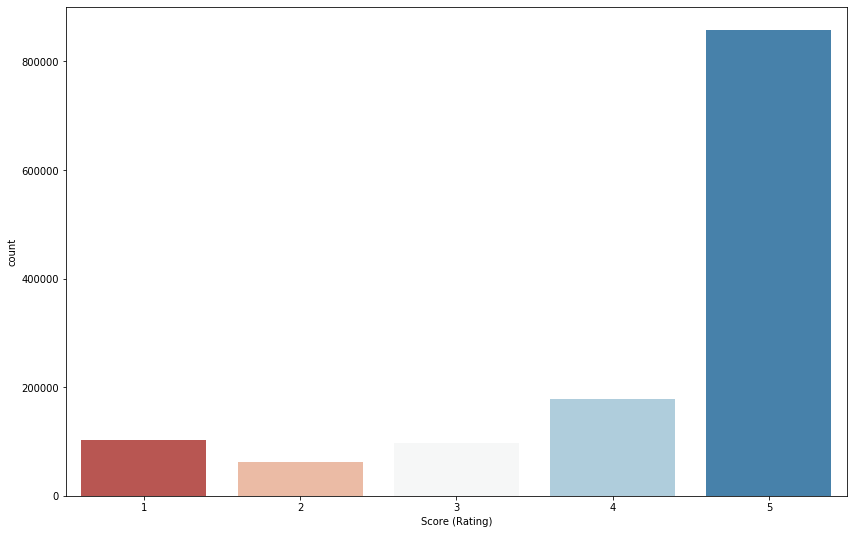

In [13]:
#Importing Seaborn and Matplotlib for graphical effects.
# Below we plot number of reviewers based on rating
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14,9))
sns.countplot(x='overall', data=final_df, palette='RdBu')
plt.xlabel('Score (Rating)')
plt.show()

## B1 Popular words in the Review

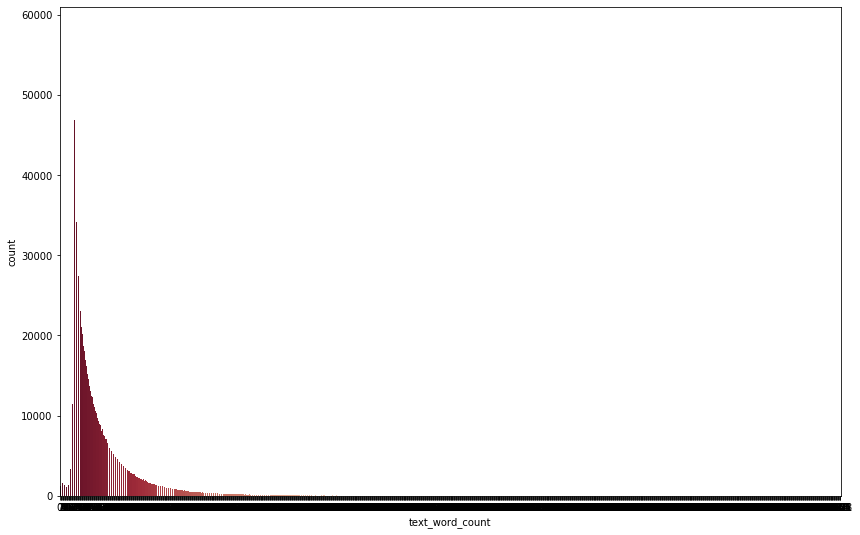

In [49]:
final_df["text_word_count"] = final_df["reviewText"].apply(lambda text: len(text.split()))
plt.figure(figsize=(14,9))
sns.countplot(x='text_word_count', data=final_df, palette='RdBu')
plt.xlabel('text_word_count')
plt.show()

In [15]:
final_df[final_df.overall==5].text_word_count.median()


38.0

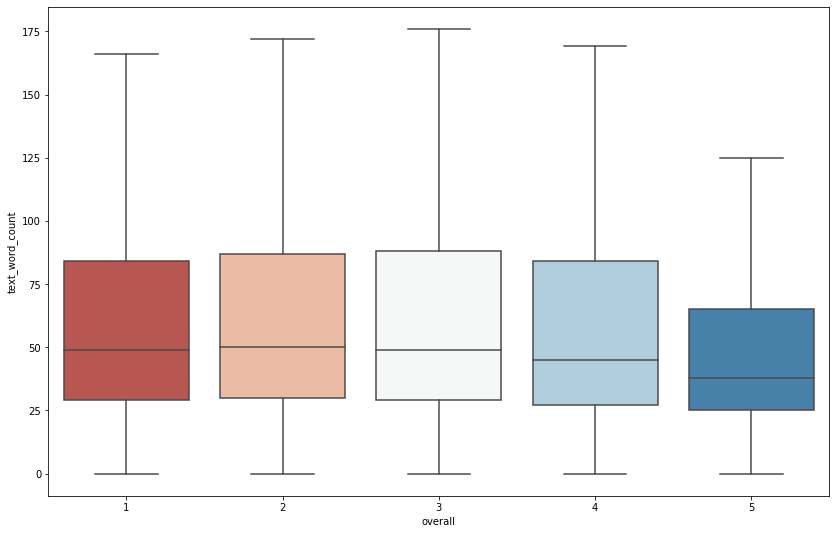

In [16]:
plt.figure(figsize=(14,9))
sns.boxplot(x='overall',y='text_word_count', data=final_df, palette='RdBu', showfliers=False)


## B.2 Frequency of reviewers


In [17]:

freq_user = final_df.reviewerID.value_counts()
freq_user.to_dict()
print("converted Series to dictionary")

converted Series to dictionary


In [18]:
final_df["reviewer_freq"] = final_df["reviewerID"].apply(lambda counts: "Frequent (>50 reviews)" \
                                                                 if freq_user[counts]>50 else "Not Frequent (1-50)")

## B.3 Are frequent reviewers more verbose?

The distributions of word counts for frequent and infrequent reviews shows that infrequent reviewers have a large amount of reviews of low word count. On the other hand, the largest concentration of word count is higher for frequent reviewers than for infrequent reviews. Moreover, the median word count for frequent reviewers is higher than the median for infrequent reviewers.

(-50, 400)

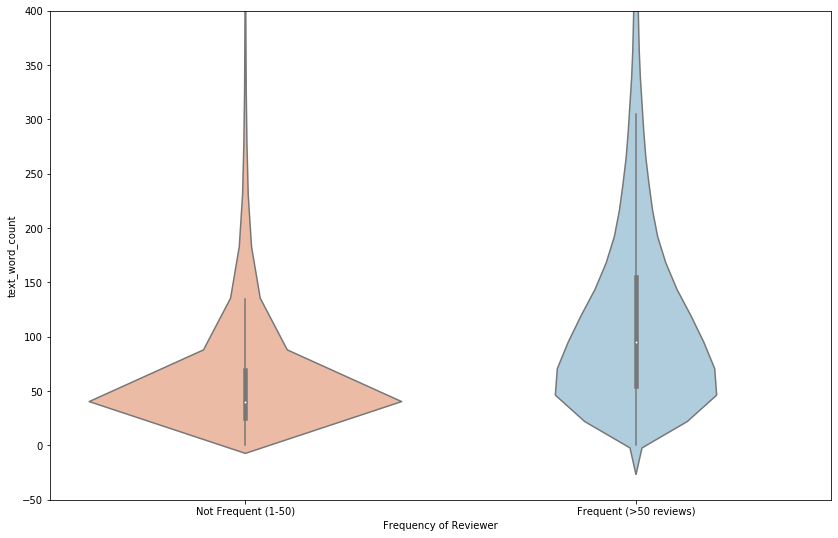

In [19]:
plt.figure(figsize=(14,9))

sns.violinplot(x='reviewer_freq', y='text_word_count',  \
               data=final_df, palette='RdBu')
plt.xlabel('Frequency of Reviewer')
plt.ylim(-50, 400)


## B.4 Review text Analysis

In [37]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim
import collections
from afinn import Afinn
%matplotlib inline






##Remove special characters from the review text
final_df['reviewText'] = final_df['reviewText'].str.replace("'", "")
final_df['reviewText'] = final_df['reviewText'].str.replace('[^a-zA-Z\s]',' ')




#Download stopwords and wordnet for lemmatization (only need to be executed once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanakara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kanakara/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [38]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

# Here we don't need stemming, because Afinn has same score for the before stemmed ones.
# stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    # return [stemmer.stem(word) for word in no_stopwords]
    return [(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

['ordered', 'spongbob', 'slippers', 'got', 'john']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanakara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
stemmed = final_df.copy()
stemmed = stemmed[stemmed['overall'] < 3]
stemmed['reviewStemmed'] = stemmed['reviewText'].apply(lambda x : process_text(x))

stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,..."
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake..."
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh..."
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi..."
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m..."


In [50]:
def flatten(nested_list):
    return [e for inner_list in nested_list for e in inner_list]

In [51]:
l_stemmed = stemmed['reviewStemmed'].values.tolist()
l_stemmed = flatten(l_stemmed)

In [52]:
frequentWords = collections.Counter(l_stemmed).most_common()[0:50000]
frequentWords = [word for word, count in frequentWords]


## Zipf's Law

Zipf's law is an empirical law formulated using mathematical statistics. The law is named after the linguist George Kingsley Zipf, who first proposed it

Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Another way to state Zipf's law is: small number of words are used all the time, while majority of words are used rarely

In [57]:
frequentWords = collections.Counter(l_stemmed).most_common()
df = pd.DataFrame(frequentWords, columns = ['FrequentWords' , 'Count']).set_index('FrequentWords')

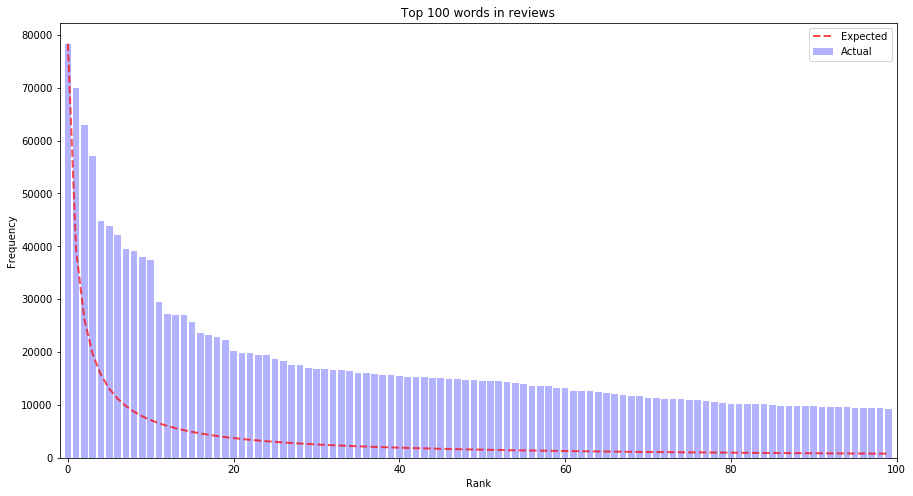

In [62]:
n_words = 100
x = np.arange(n_words)
y = df.iloc[:n_words, 0]
most_frequent_word = y[0]
expected_zipf = [most_frequent_word / (i + 1) for i in range(n_words)]

plt.figure(figsize=(15, 8))
plt.bar(x, y, alpha=0.3, color='b')
plt.plot(x, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.7)

plt.xlim([-1, n_words])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Top {} words in reviews'.format(n_words))
plt.legend(['Expected', 'Actual'])



X axis is rank of frequency from highest rank from left up to 100th rank to the right.

Y axis is frequency of words in given corpus.

We can see that plot follows the trend of Zipf's law. Actual observations in most cases does not strictly follow Zipf’s distribution, but rather follow a trend of “near-Zipfian” distribution.


# C Labelling data

Using the Amazon dataset, our goal is to detect any potential harmful products by analyzing the user reviews and classifying them as presenting or not a possible health threat. Unfortunately, we lack the annotated data that would be needed to build a classifier.

We will thus create our own annotated data by using **empath** ,**affin** and  **fda recall reason text** . **Empath** is a python library that can be used to analyze documents over a set of predefined categories, and even generate new categories.  **Affin** is a python library which gives the ability to append and overwrite word / value pairs from the AFINN wordlist  rated for valence with an integer between minus five (negative) and plus five (positive). Sentiment analysis is performed by cross-checking the string tokens (words, emojis) with the AFINN list and getting their respective scores. **FDA recall** we use two fda datasets: Fda enforcement and fda press release, using which we build a list of words (library) by parsing fda recall reason text.

We start by importing the affin library.

## C1 Labeling the amazon reviews with empath sentiment analysis.

In [64]:
from empath import Empath

We then create a new lexical category **healthConcerns** as a combination of the seeds words **health**, **danger** and **food poisoning**.

In [65]:
lexicon = Empath()

lexicon.create_category('healthConcerns', \
                        seeds=['health', 'danger', 'food poisoning'])


["health", "danger", "welfare", "human_life", "illness", "sickness", "necessity", "safety", "responsibility", "mental_state", "dangers", "well-being", "risk", "lifemate", "knowledge", "survival", "consequence", "humanity", "recovery", "exposure", "risks", "capacity", "wellbeing", "peril", "potential", "responsibilities", "downfall", "death", "loyalty", "bloodline", "fear", "judgement", "poverty", "responsible", "threat", "condition", "importance", "treatment", "current_state", "disease", "discipline", "top_priority", "judgment", "affairs", "healing", "cruelty", "human_race", "sacrifice", "ensure", "demise", "hardship", "separation", "vital", "healer", "losses", "likelihood", "environment", "Psy", "hazard", "corruption", "independence", "future", "own_safety", "needs", "killing", "normalcy", "Council", "suffering", "stability", "virtue", "disability", "sacrifices", "conditions", "free_will", "failure", "therefore", "carelessness", "involvement", "mindset", "unborn_child", "relations", "

In [66]:
def analyze(x):
    ret = lexicon.analyze(x, categories=["healthConcerns"])
    if (ret == None):
        return 0.0
    else:
        return ret.get('healthConcerns')

We now create a new column do our dataframe, obtained by analyzing the reviews and assigning them a score. The higher the score is, the more that review exposes possible health concerns. 

In [67]:
empathy = final_df.copy()
empathy['healthScore'] = empathy['reviewText'].apply(lambda x : analyze(x))

empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,5,2013-10-11,[[Grocery & Gourmet Food]],NaN,88,Not Frequent (1-50),0.0
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,5,2012-12-06,[[Grocery & Gourmet Food]],NaN,119,Not Frequent (1-50),0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,37,Not Frequent (1-50),0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,61,Not Frequent (1-50),0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,64,Not Frequent (1-50),0.0


Now that all our reviews have been assign a score, let's have a look at its distribution.

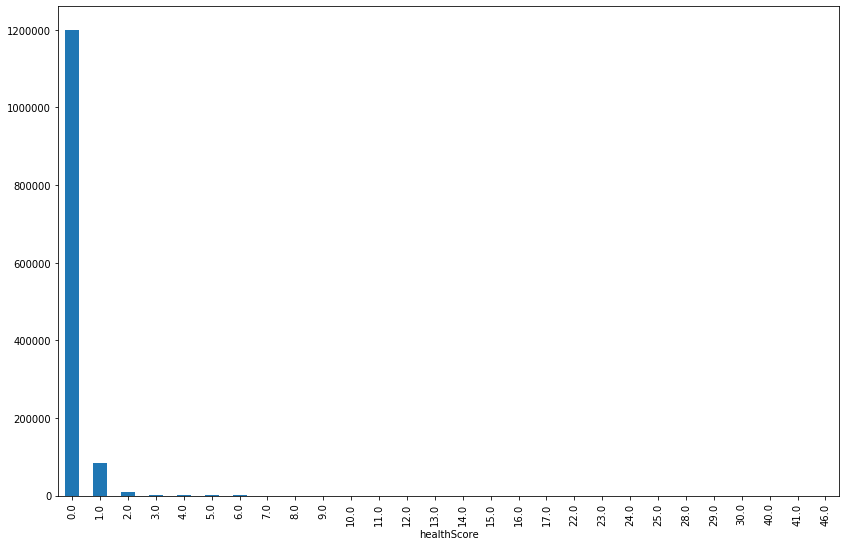

In [183]:
plt.figure(figsize=(14,9))
empathy.groupby(by='healthScore').count()['reviewText'].plot.bar()

As expected, we observe that a vast majority of the reviews don't expose any kind of health-related issues (symbolized by the pic at x = 0). Let's dive deeper and have a closer look at the reviews with a score bigger than 0.

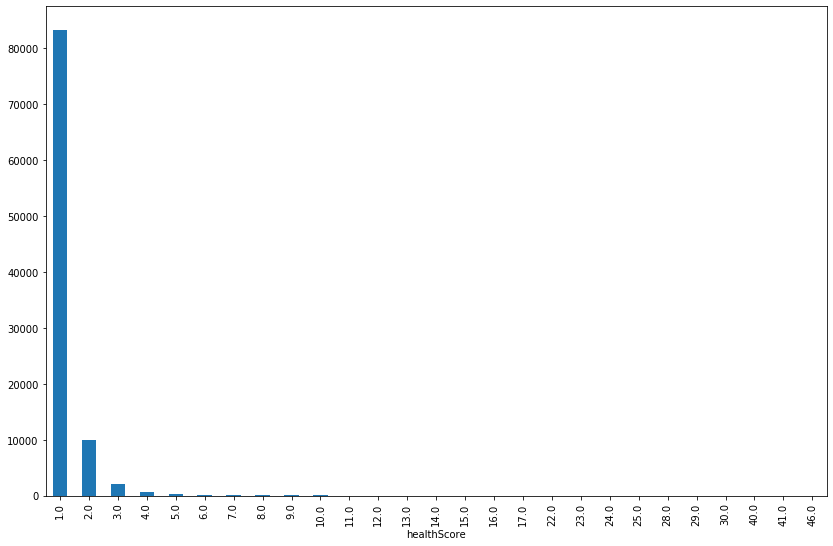

In [184]:
plt.figure(figsize=(14,9))
empathyScore = empathy[empathy['healthScore'] > 0]

empathyScore.groupby(by='healthScore').count()['reviewText'].plot.bar()

<Figure size 1120x720 with 0 Axes>

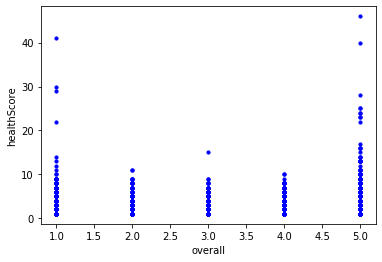

<Figure size 1120x720 with 0 Axes>

In [197]:
empathyScore.plot.scatter('overall', 'healthScore',s=10 ,c='b')
plt.figure(figsize=(14, 9), dpi=80)


We observe here something pretty unexpected : most of the reviews with a high healthScore have an associated rating of 3 or more, with the highest healthScore at x=5. A fair assumption would be that a reviewer exposed to health issues due to a product would attribute it a low score, which is not the case here. Let's have a look at the reviews themselves now, to gain more insights.

In [71]:
empathyScore[empathyScore['overall'] == 5].sort_values(by='healthScore', ascending=False).head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore
632161,A1FLQ698D9C0C8,B002P0Q14C,Tea Antioxidants Antioxidants c...,5,2009-09-13,[[Grocery & Gourmet Food]],NaN,1931,Not Frequent (1-50),46.0
388784,A1J7FP5XCCSHSM,B001AG6BMO,Uses for Coconut Oil Coconut Oil Is Anti b...,5,2012-03-22,"[[Grocery & Gourmet Food, Cooking & Baking, Co...",Garden of Life,4738,Not Frequent (1-50),40.0
428754,A3RR2P5IS3DGPR,B001E5E2MC,I love each of my Beef Pork Lamb Fish and t...,5,2010-04-24,[[Grocery & Gourmet Food]],NaN,2417,Frequent (>50 reviews),28.0
286194,A356RFKNIG043B,B000R71WMQ,I cant begin to praise apple cider vinegar ac...,5,2014-04-05,[[Grocery & Gourmet Food]],Bragg,1423,Not Frequent (1-50),25.0
1243839,AUYT2H281GPNJ,B00DS842HS,Well the wife and I have been using coconut o...,5,2013-10-02,[[Grocery & Gourmet Food]],Viva Labs,1401,Not Frequent (1-50),25.0


In [72]:
[x[:1000] for x in empathyScore[empathyScore['overall'] == 5] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:2]]

['Tea Antioxidants                Antioxidants can help the body protect itself against free radicals  molecules that can damage cells  Antioxidants in tea called flavonoids can do that Whether iced or hot  Teas made from real tea leaves provide more than great taste  Like fruits and vegetables  regular and decaffeinated brewed teas contain natural antioxidants called flavonoids                   Research suggests that antioxidants can be beneficial to health by helping the body protect itself from the harmful effects of  free radicals                       Free radicals  molecules which occur in the environment and are naturally produced by the body  can cause damage to cells  Chronic damage by free radicals is one factor thought to contribute to the development of many chronic diseases including heart disease or cancer  An average cup of brewed green or black tea has         mg of flavonoids         Currently  teas potential health benefits are the focus of many scientific studies  a

As we see with those reviews, there seems to be something off with them (note that, for readability purposes, we only show the first thousand characters of those reviews) : they look more like some ad of the product's benefits/usages than actual reviews. Our initial assumption seems thus accurate : even though those "reviews" are health-related, they are not what we are looking for. We are thus going to ignore them. Let's continue our analysis with the reviews with score 3 and 4.

In [73]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 4] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

['I am always looking for an alternative sweetener to get away from fructose  Most of the artificial sweeteners on the market are terrible for your health   I will name splenda as one of the worse  Stevia is made directly from the dried leaves of the Stevia plant so that is acceptable  but I find it kind of bitter and it is very expensive  You can google  xylitol benefits  and get all kinds of interesting information  but I will just reiterate some of the very interesting benefits I found when googling Xylitol is a natural sugar alcohol that has been recognized by dentists and health professionals worldwide as a great alternative to white sugar Commonly found in chewing gum and breathmints  Xylitol is known to have a many health benefits associated with its use    Safe For DiabeticsUnlike sugar  xylitol is not easily converted to fat  Because it is not easily converted to fat  it has almost no effect on insulin levels  making it a safe sugar alternative for diabetics  body builders  di

In [74]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 3] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

['Yerba Mate  like caffeine  is a stimulant   Both increase heart rate  blood pressure and impact various metabolic processes that work cooperatively to maintain homeostasis within your body   In moderate amounts each can be tolerated without incident in well adults  Yerba Mate compounds are not likely to pose a risk for healthy well adults who occasionally drink it However  some studies indicate that  certain people who drink large amounts of yerba mate over prolonged periods may be at increased risk of certain types of cancer  such as cancer of the mouth  esophagus and lungs  Those with Thyroid or auto immune conditions are at greater risk for developing thyroid goiters  cancers and lymphatic cancers   Smoking  drinking or prolonged high blood sugar in combination with yerba mate seems to greatly increase serious health risks such as cancer One possible explanation is that mate contains polycyclic aromatic hydrocarbons  PAHs   which are known to be carcinogenic   Tobacco smoke and gr

We see that reviews with a 4 score don't really assert the reviewed product's health issues, but its competitors or other aspects. Whereas the reviews rated 3-stars seem to correspond to what we were looking for.

Thus, for our labelled data, we're going to limit ourselves to the reviews with a healthScore strictly positive, and with a rating smaller or equal to 3.

In [75]:
empathy['danger'] = np.where(np.logical_and(empathy['healthScore'] > 0., empathy['overall'] < 4), \
                             True, False)


empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,5,2013-10-11,[[Grocery & Gourmet Food]],NaN,88,Not Frequent (1-50),0.0,False
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,5,2012-12-06,[[Grocery & Gourmet Food]],NaN,119,Not Frequent (1-50),0.0,False
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,37,Not Frequent (1-50),0.0,False
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,61,Not Frequent (1-50),0.0,False
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,64,Not Frequent (1-50),0.0,False


In [76]:
print("Number of reviews that we will use as labelled data : {}" \
      .format(len(empathy[empathy['danger']])))

Number of reviews that we will use as labelled data : 20253


## C2 Labeling the amazon reviews with Afinn sentiment analysis.

In [40]:
afinn = Afinn()

# Compute affin score for all the stemmed words
stemmed['afinnWords'] = stemmed['reviewText'].apply(lambda x : afinn.find_all(x))
stemmed['afinnScores'] = stemmed['reviewText'].apply(lambda x : afinn.scores_with_pattern(x))
stemmed['afinnTotalScore'] = stemmed['reviewText'].apply(lambda x : afinn.score_with_pattern(x))
stemmed['afinnWordsLen'] = stemmed['afinnWords'].apply(lambda x : len(x))

In [171]:
stemmed['afinnMeanScore'] = (stemmed['afinnTotalScore']/stemmed['afinnWordsLen']).round()

In [172]:
stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,FDA_press_released,FDA_enforced,afinnMeanScore
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,...",[happy],[3],3.0,1,[],"[ordered, ordered]",3.0
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake...","[bad, mistake, pay, pay]","[-3, -2, -1, -1]",-7.0,4,[bottle],"[item, quantity, per, bottle]",-2.0
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh...","[harsh, apologize, disappointed, protect, hope...","[-2, -1, -2, 1, 2, -2]",-4.0,6,"[product, product, problem]","[product, received, product, boxes, tea, boxes...",-1.0
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi...","[excited, good, destroyed, mad, disappointed, ...","[3, 3, -3, -3, -2, 3]",1.0,6,"[package, package]","[good, package, crunch, two, package, made]",0.0
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m...","[like, bad]","[2, -3]",-1.0,2,[],"[green, tea, taste, came]",-0.0


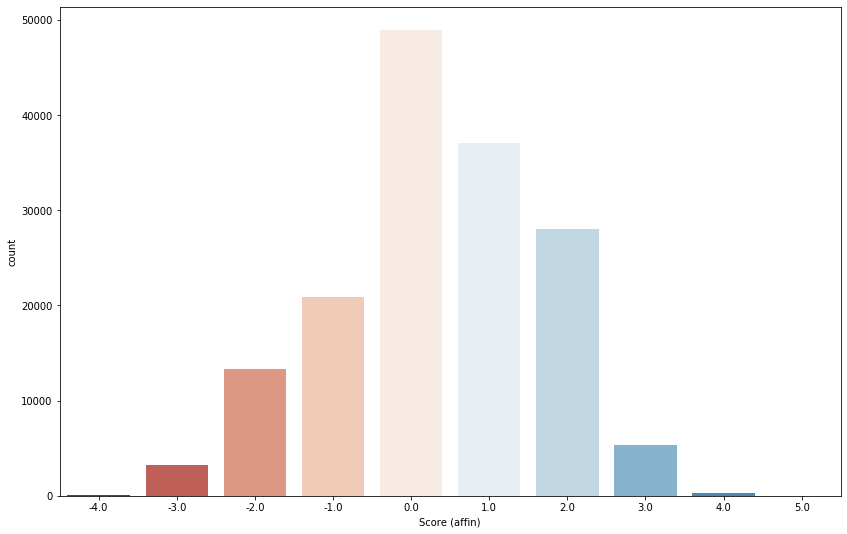

In [173]:
plt.figure(figsize=(14,9))
sns.countplot(x='afinnMeanScore', data=stemmed, palette='RdBu')
plt.xlabel('Score (affin)')
plt.show()

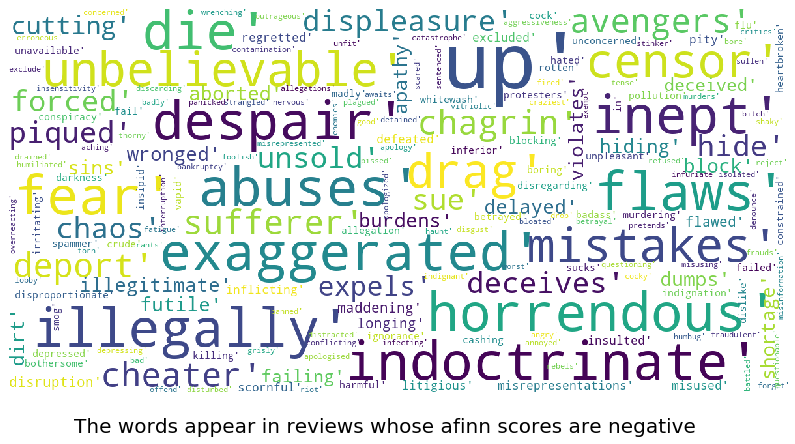

In [207]:
l_words = stemmed['afinnWords'].values.tolist()
l_words = flatten(l_words)
l_scores = stemmed['afinnScores'].values.tolist()
l_scores = flatten(l_scores)
words_scores = list(zip(l_words, l_scores))
negative_scores = set([word for word, score in words_scores if score<0])
show_wordcloud(negative_scores, title = "The words appear in reviews whose afinn scores are negative")


In [45]:
# Compute affin score for all the frequent stemmed words


stemmed_frequent = stemmed.copy()
stemmed_frequent['afinnWords'] = stemmed['afinnWords'].apply(lambda x : [i for i in x if i in frequentWords])
stemmed_frequent['afinnScores'] = stemmed_frequent['reviewText'].apply(lambda x : afinn.scores_with_pattern(x))
stemmed_frequent['afinnTotalScore'] = stemmed_frequent['reviewText'].apply(lambda x : afinn.score_with_pattern(x))
stemmed_frequent['afinnWordsLen'] = stemmed_frequent['afinnWords'].apply(lambda x : len(x))

In [167]:
stemmed_frequent['afinnMeanScore'] = (stemmed_frequent['afinnTotalScore']/stemmed_frequent['afinnWordsLen']).round()

In [170]:
stemmed_frequent.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,afinnMeanScore
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,...",[happy],[3],3.0,1,3.0
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake...","[bad, mistake, pay, pay]","[-3, -2, -1, -1]",-7.0,4,-2.0
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh...","[harsh, apologize, disappointed, protect, hope...","[-2, -1, -2, 1, 2, -2]",-4.0,6,-1.0
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi...","[excited, good, destroyed, mad, disappointed, ...","[3, 3, -3, -3, -2, 3]",1.0,6,0.0
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m...","[like, bad]","[2, -3]",-1.0,2,-0.0


In [180]:
stemmed_frequent['afinnMeanScore']= stemmed_frequent['afinnMeanScore'].replace([np.inf, -np.inf], np.nan)

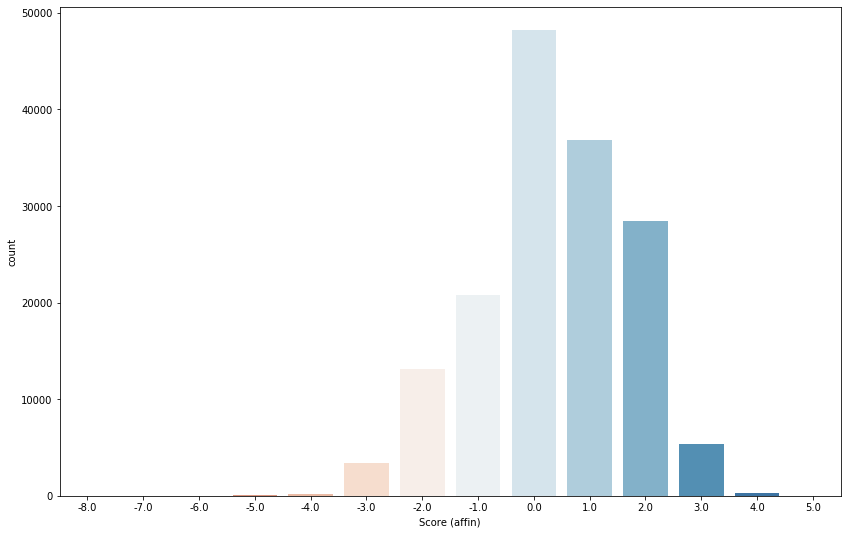

In [181]:
plt.figure(figsize=(14,9))
sns.countplot(x='afinnMeanScore', data=stemmed_frequent, palette='RdBu')
plt.xlabel('Score (affin)')
plt.show()

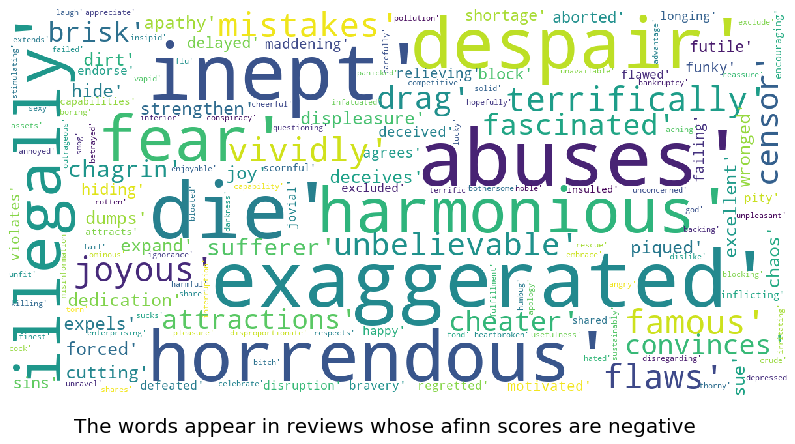

In [209]:
l_words = stemmed_frequent['afinnWords'].values.tolist()
l_words = flatten(l_words)
l_scores = stemmed_frequent['afinnScores'].values.tolist()
l_scores = flatten(l_scores)
words_scores = list(zip(l_words, l_scores))
negative_scores = set([word for word, score in words_scores if score<0])
show_wordcloud(negative_scores, title = "The words appear in reviews whose afinn scores are negative")


In [78]:
stemmed_frequent.groupby(by=['afinnWordsLen']).describe()

overall                                               \
                 count      mean       std  min  25%  50%  75%  max   
afinnWordsLen                                                         
0               7688.0  1.351197  0.477375  1.0  1.0  1.0  2.0  2.0   
1              20042.0  1.384243  0.486428  1.0  1.0  1.0  2.0  2.0   
2              26525.0  1.386993  0.487071  1.0  1.0  1.0  2.0  2.0   
3              25537.0  1.380977  0.485636  1.0  1.0  1.0  2.0  2.0   
4              20401.0  1.374197  0.483927  1.0  1.0  1.0  2.0  2.0   
...                ...       ...       ...  ...  ...  ...  ...  ...   
139                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
143                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
177                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
200                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
249                1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0   

              text_word_count               ...                  \
                        count         mean  ...     75%     max   
afinnWordsLen                               ...                   
0                      7688.0    28.941727  ...    34.0  1624.0   
1                     20042.0    32.541463  ...    39.0   203.0   
2                     26525.0    37.347257  ...    45.0   181.0   
3                     25537.0    44.520930  ...    56.0   227.0   
4                     20401.0    54.399686  ...    68.0   263.0   
...                       ...          ...  ...     ...     ...   
139                       1.0  1939.000000  ...  1939.0  1939.0   
143                       1.0  2400.000000  ...  2400.0  2400.0   
177                       1.0  2537.000000  ...  2537.0  2537.0   
200                       1.0  2913.000000  ...  2913.0  2913.0   
249                       1.0  3368.000000  ...  3368.0  3368.0   

              afinnTotalScore                                             \
                        count        mean       std    min    25%    50%   
afinnWordsLen                                                              
0                      7688.0   -0.066207  0.413022   -9.0    0.0    0.0   
1                     20042.0    0.306407  2.197741   -8.0   -2.0    1.0   
2                     26525.0    0.676079  3.149297  -10.0   -1.0    1.0   
3                     25537.0    0.977562  3.932207  -13.0   -2.0    1.0   
4                     20401.0    1.372874  4.660822  -14.0   -2.0    1.0   
...                       ...         ...       ...    ...    ...    ...   
139                       1.0  -32.000000       NaN  -32.0  -32.0  -32.0   
143                       1.0   64.000000       NaN   64.0   64.0   64.0   
177                       1.0  -16.000000       NaN  -16.0  -16.0  -16.0   
200                       1.0   46.000000       NaN   46.0   46.0   46.0   
249                       1.0  383.000000       NaN  383.0  383.0  383.0   

                             
                 75%    max  
afinnWordsLen                
0                0.0    0.0  
1                2.0    5.0  
2                4.0    9.0  
3                4.0   12.0  
4                5.0   14.0  
...              ...    ...  
139            -32.0  -32.0  
143             64.0   64.0  
177            -16.0  -16.0  
200             46.0   46.0  
249            383.0  383.0  

[92 rows x 24 columns]

## C3 Labeling the amazon reviews with FDA Recall data sets.

In [81]:
df_press_released = pd.read_csv(path_press_released)
df_enforced = pd.read_csv(path_enforced, encoding = 'unicode_escape')

In [82]:
stemmed_press_released = df_press_released.copy()
stemmed_press_released['stemmed_Reason'] = stemmed_press_released['Reason'].astype(str).apply(lambda x : process_text(x))
stemmed_enforced = df_enforced.copy()
stemmed_enforced['stemmed_Reason.for.Recall'] = stemmed_enforced['Reason.for.Recall'].astype(str).apply(lambda x : process_text(x))

In [83]:
stemmed_press_released.head()

,Unnamed: 0,Date,Brand,ProductDescription,Reason,Company,Url,stemmed_Reason
0,0,"Sat, 31 Dec 2011 22:37:00 -0500","Let&#39;s Grow Healthy Together!, Green Valley...",Sprouts,Listeria monocytogenes,Green Valley Food Corp.,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
1,1,"Sat, 31 Dec 2011 00:00:00 -0500",Edelweiss Creamery,cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
2,2,"Sat, 31 Dec 2011 00:00:00 -0500",Brennan&#39;s Cellars,Cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
3,3,"Fri, 30 Dec 2011 00:00:00 -0500",Martinelli&#39;s Gold Medal,Sparkling Cider,Defective Seal,S. Martinelli &amp; Company,http://wayback.archive-it.org/7993/20170406200...,"[defective, seal]"
4,4,"Fri, 30 Dec 2011 00:00:00 -0500",Organique by Himalaya,Night Cream,staphylococcus aureus and fungus,HimalayaUSA,http://wayback.archive-it.org/7993/20170406200...,"[staphylococcus, aureus, fungus]"


In [84]:
stemmed_enforced.head()

,Product.Type,Recently.Updated.Record,Last.Modified.Date,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,...,Product.Description,Product.Quantity,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,More.Code.Info,stemmed_Reason.for.Recall
0,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Macaroni Reg CAD, Formula MA.50, Macaroni Sal...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by dates: 10/21/13-12/11/13.,NaN,"[the, recalled, products, potentially, contami..."
1,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Cheesy Macaroni Salad, For...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 and 12/01/13.,NaN,"[the, recalled, products, potentially, contami..."
2,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Potato Salad, Formula PO.9...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/23/13-12/09/13.,NaN,"[the, recalled, products, potentially, contami..."
3,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Egg, Formula PO.71, packaged...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 - 12/12/13.,NaN,"[the, recalled, products, potentially, contami..."
4,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Deviled Egg, Formula PO.16, ...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/13/2013 - 11/15/13.,NaN,"[the, recalled, products, potentially, contami..."


In [89]:
# Make lists of reason sentences in the press released dataset and the enforced dataset

l_stemmed_press_released = stemmed_press_released['stemmed_Reason'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed_enforced['stemmed_Reason.for.Recall'].values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [90]:
# Count how many times each word appears in these words lists.
# Remove words that have less than two characters.

press_released_sorted = collections.Counter(l_stemmed_press_released).most_common()
enforced_sorted = collections.Counter(l_stemmed_enforced).most_common()

# Sort these two lists by count
words_press_released_sorted = [word for word, count in press_released_sorted if len(word)>2]
words_enforced_sorted = [word for word, count in enforced_sorted if len(word)>2]

In [133]:
# With using wordcloud library, make a function visualizes the words in these two lists
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(14, 9))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.5)

    plt.imshow(wordcloud)
    plt.show()

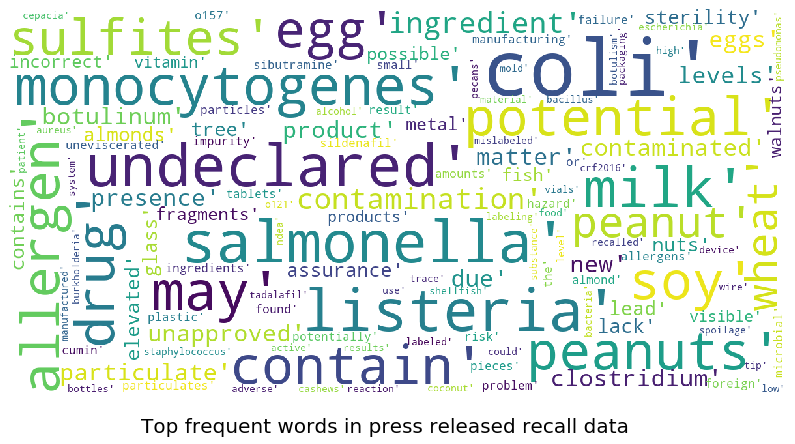

In [134]:
# Visualize the top 200 frequent words in the press released reason sentenses
show_wordcloud(words_press_released_sorted[:200], title = "Top frequent words in press released recall data")

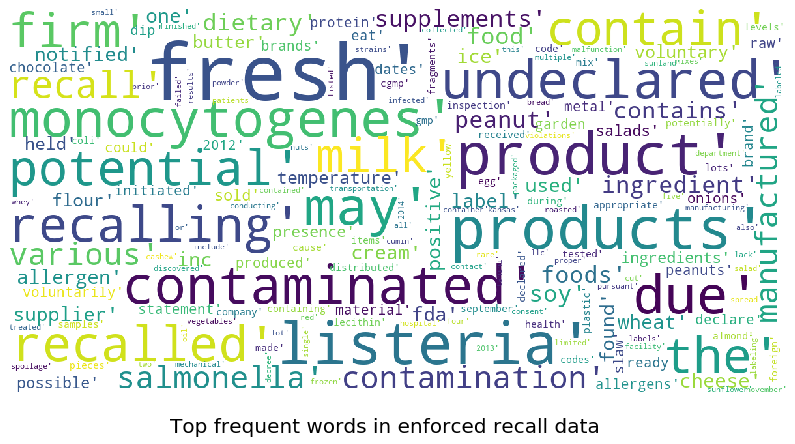

In [135]:
# Visualize the top 200 frequent words in the enforced reason sentenses
show_wordcloud(words_enforced_sorted[:200], title = "Top frequent words in enforced recall data")

Here, we got words lists from both the press released dataset and the enforced dataset. We can see that these words strongly connect to health problems.  
Then, in these lists, there might be some usuless words that appear few times. Let's check these words and delete them.

In [136]:
# Count all of the words in each list
counts_press_released = pd.Series([count for word, count in press_released_sorted if len(word)>2])
counts_enforced = pd.Series([count for word, count in enforced_sorted if len(word)>2])

Text(0.5, 1.0, 'Histogram of counts of words appear in the enforced dataset')

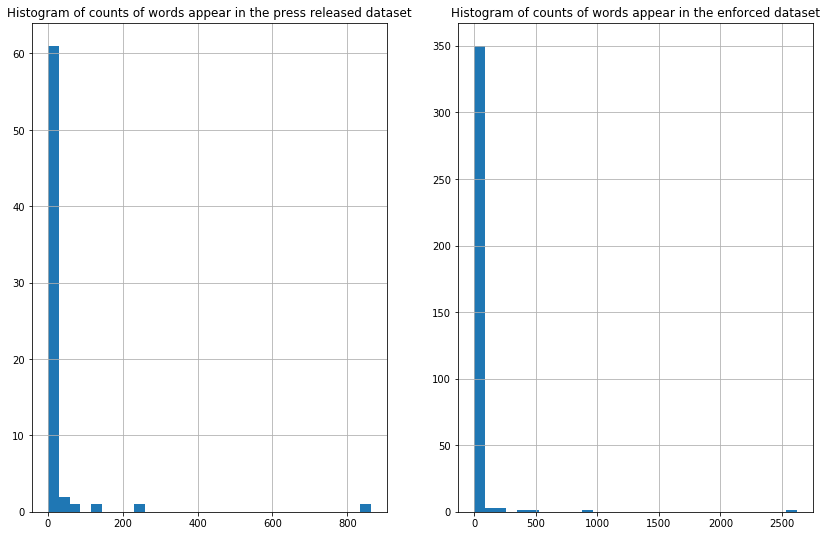

In [137]:
# Plot the histograms of word counts in each list
plt.figure(figsize=(14, 9))

plt.subplot(1,2,1)
counts_press_released.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the press released dataset")

plt.subplot(1,2,2)
counts_enforced.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the enforced dataset")

In [138]:
print("The ratio of words that appear only once in words_press_released_sorted is {:.1f}%".format(counts_press_released.value_counts()[1]/len(words_press_released_sorted)*100))
print("The ratio of words that appear only once in words_enforced_sorted is {:.1f}%".format(counts_enforced.value_counts()[1]/len(words_enforced_sorted)*100))

The ratio of words that appear only once in words_press_released_sorted is 55.6%
The ratio of words that appear only once in words_enforced_sorted is 36.3%


In [139]:
# Let's see inside the press released  word list with specified word count 2 & 3
words_press_released_3 = [word for word, count in press_released_sorted if count==3 if len(word)>2]
words_press_released_4 = [word for word, count in press_released_sorted if count==4 if len(word)>2]

In [140]:
# Let's see inside the enforced word list with specified word count 5 & 10
words_enforced_5 = [word for word, count in enforced_sorted if count==5 if len(word)>2]
words_enforced_10 = [word for word, count in enforced_sorted if count==10 if len(word)>2]
words_enforced_15 = [word for word, count in enforced_sorted if count==15 if len(word)>2]

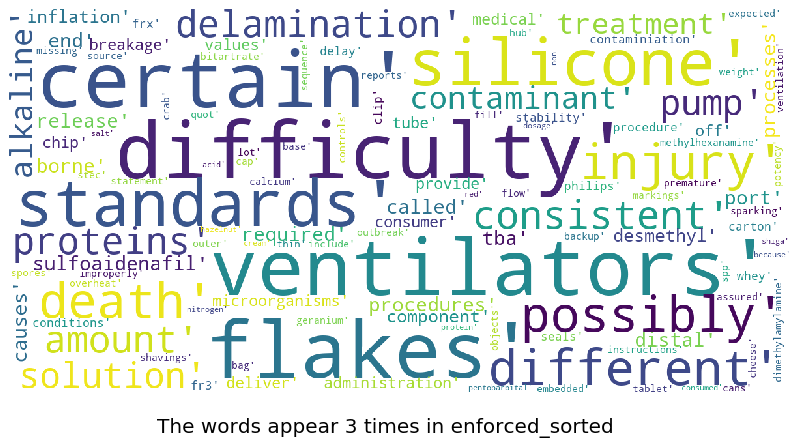

In [210]:
show_wordcloud(words_press_released_3, title = "The words appear 3 times in enforced_sorted")

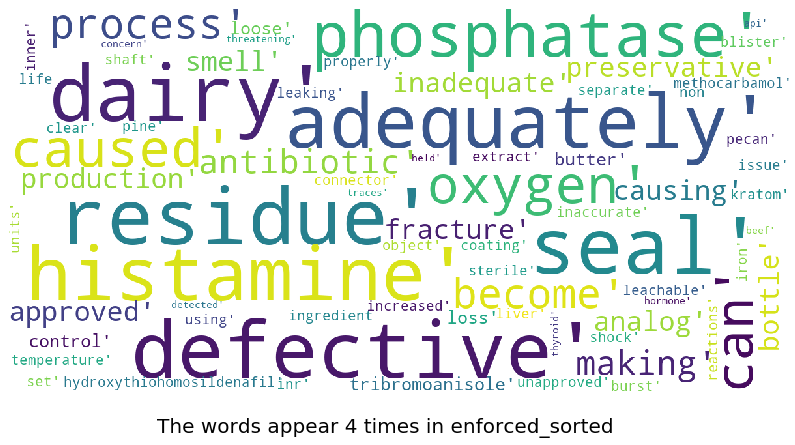

In [211]:
show_wordcloud(words_press_released_4, title = "The words appear 4 times in enforced_sorted")

Here, from count more than 4, the useless words ratio like "become" and "process" is small. (When we increase the minimum count like 10, we still have some useless words, so we analyzed compromise point to get useful health words.)

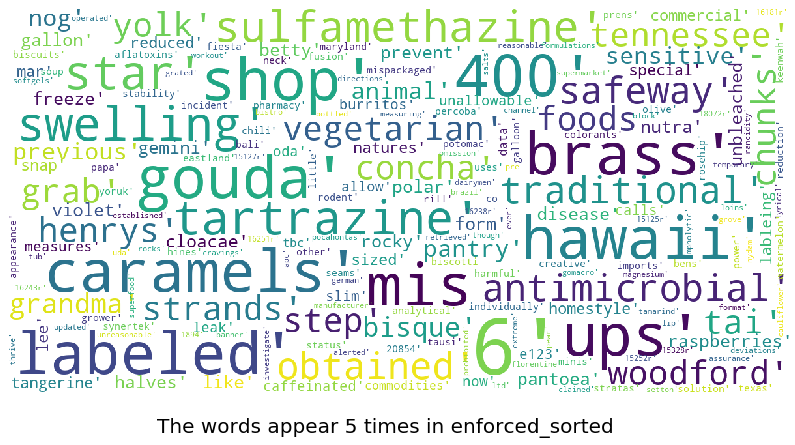

In [212]:
show_wordcloud(words_enforced_5, title = "The words appear 5 times in enforced_sorted")

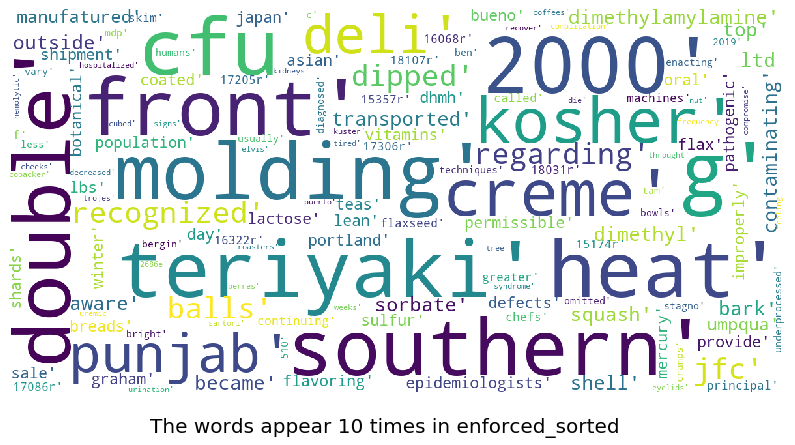

In [213]:
show_wordcloud(words_enforced_10, title = "The words appear 10 times in enforced_sorted")

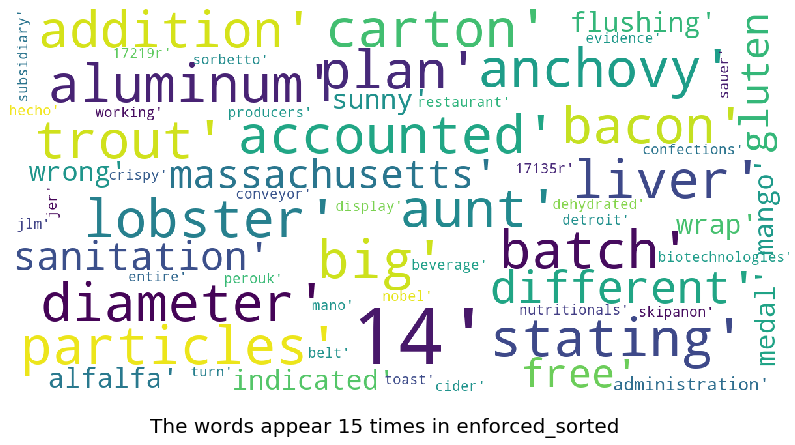

In [214]:
show_wordcloud(words_enforced_15, title = "The words appear 15 times in enforced_sorted")

Here, from count more than 15, the useless words ratio like "14" and "massachusetts" is small. (When we increase the minimum count like 20, we still have some useless words, so we analyzed compromise point to get useful health words.)

In [147]:
frequent_words_press_released = [word for word, count in press_released_sorted if count >= 4 if len(word)>2]
frequent_words_enforced = [word for word, count in enforced_sorted if count >= 30  if len(word)>2]

In [148]:
stemmed['FDA_press_released'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_press_released])
stemmed['FDA_enforced'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_enforced])

In [149]:
stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,FDA_press_released,FDA_enforced
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,...",[happy],[3],3.0,1,[],"[ordered, ordered]"
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake...","[bad, mistake, pay, pay]","[-3, -2, -1, -1]",-7.0,4,[bottle],"[item, quantity, per, bottle]"
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh...","[harsh, apologize, disappointed, protect, hope...","[-2, -1, -2, 1, 2, -2]",-4.0,6,"[product, product, problem]","[product, received, product, boxes, tea, boxes..."
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi...","[excited, good, destroyed, mad, disappointed, ...","[3, 3, -3, -3, -2, 3]",1.0,6,"[package, package]","[good, package, crunch, two, package, made]"
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m...","[like, bad]","[2, -3]",-1.0,2,[],"[green, tea, taste, came]"


In [150]:
l_stemmed_press_released = stemmed['FDA_press_released'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed['FDA_enforced'] .values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [154]:
print(len(set(l_stemmed_press_released)))

278


In [156]:
print(len(set(l_stemmed_enforced)))

853


## What's up next

Now that we have created some labelled data, we will now be able to build a classifier able to classify reviews as exposing potential health threaths. This will serve as both a way to handle potentially new reviews, but also detect reviews that we potentially missed earlier. 

Notice that we made a few assumptions during our label creation, which might not always hold. Notice also that our healthConcern category created in empath might not be exhaustive enough to capture all health-related issues. A classifier would be able to solve those issues.

Once we have our classifier and (hopefully) all our reviews, we will explore them in depth, trying to draw any meaningful insights (for example if we see any meaningful pattern in the health-related reviews on a time basis, if there are some brands that demarks themselves with the number of their products that exposes such concerns etc..)